c:\Program Files\Python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


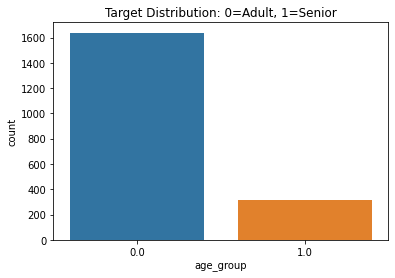

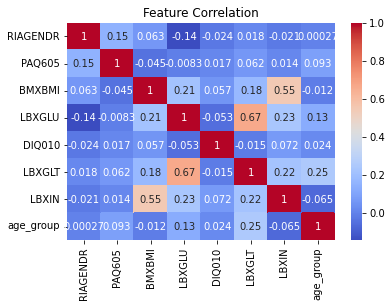

Logistic Regression Accuracy: 0.8670076726342711
Random Forest Accuracy: 0.8670076726342711
XGBoost Accuracy: 0.8209718670076727

 Best Model: Logistic with Accuracy: 0.8670076726342711


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load datasets
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")
sample_submission = pd.read_csv("Sample_Submission.csv")

# Encode target: 'Adult'=0, 'Senior'=1
train_df["age_group"] = train_df["age_group"].map({"Adult": 0, "Senior": 1})
train_df = train_df.dropna(subset=["age_group"])  # Drop 14 rows with missing target

# Drop ID
X = train_df.drop(columns=["SEQN", "age_group"])
y = train_df["age_group"]
X_test = test_df.drop(columns=["SEQN"])

# Impute missing values using median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Target distribution
sns.countplot(x=y)
plt.title("Target Distribution: 0=Adult, 1=Senior")
plt.show()

# Correlation heatmap
sns.heatmap(train_df.drop(columns=["SEQN"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_val)
log_acc = accuracy_score(y_val, log_preds)
print("Logistic Regression Accuracy:", log_acc)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_acc = accuracy_score(y_val, rf_preds)
print("Random Forest Accuracy:", rf_acc)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
xgb_acc = accuracy_score(y_val, xgb_preds)
print("XGBoost Accuracy:", xgb_acc)

# Find best
best_model = max(
    [("Logistic", log_model, log_acc), 
     ("RandomForest", rf_model, rf_acc), 
     ("XGBoost", xgb_model, xgb_acc)],
    key=lambda x: x[2]
)

print(f"\n Best Model: {best_model[0]} with Accuracy: {best_model[2]}")

# Final test prediction
final_model = best_model[1]
final_preds = final_model.predict(X_test_imputed)

sample_submission["age_group"] = final_preds.astype(int)
sample_submission.to_csv("final_submission.csv", index=False)
